In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

In [ ]:
# Load the XML file
tree = ET.parse('CMT01.xml')
root = tree.getroot()

In [ ]:
# Extract the node and edge data from the XML file
node_list = []
demand_list = []
for node in root.findall("./network/nodes/"):
    node_id = int(node.attrib['id'])
    node_type = int(node.attrib['type'])
    node_x = float(node.find('cx').text)
    node_y = float(node.find('cy').text)
    node_list.append([node_id, node_type, node_x, node_y])
for demand in root.findall("./requests/"):
    node_id = int(demand.attrib['node'])
    node_demand = float(demand.find('quantity').text)
    demand_list.append([node_id, node_demand])

In [ ]:
# Convert the node_list and edge_list into dataframes
node_df = pd.DataFrame(node_list, columns=["id", "type", "x", "y"])
demand_df = pd.DataFrame(demand_list, columns=["id", "demand"])

In [ ]:
node_df.tail()

,id,type,x,y
46,47,1,25.0,32.0
47,48,1,25.0,55.0
48,49,1,48.0,28.0
49,50,1,56.0,37.0
50,51,0,30.0,40.0


In [ ]:
demand_df.tail()

,id,demand
45,46,5.0
46,47,25.0
47,48,17.0
48,49,18.0
49,50,10.0


In [ ]:
f=len(demand_df)

In [ ]:
from scipy.spatial import distance_matrix

In [ ]:
# Extract the x and y coordinates as a numpy array
coords = node_df[['x', 'y']].to_numpy()

# Calculate the distance matrix using the Euclidean distance metric
dist_matrix = distance_matrix(coords, coords)

In [ ]:
dist_matrix

array([[ 0.        , 12.36931688, 19.20937271, ..., 26.40075756,
        24.20743687, 13.89244399],
       [12.36931688,  0.        , 15.29705854, ..., 21.02379604,
        13.89244399, 21.02379604],
       [19.20937271, 15.29705854,  0.        , ..., 36.22154055,
        27.29468813, 32.55764119],
       ...,
       [26.40075756, 21.02379604, 36.22154055, ...,  0.        ,
        12.04159458, 21.63330765],
       [24.20743687, 13.89244399, 27.29468813, ..., 12.04159458,
         0.        , 26.17250466],
       [13.89244399, 21.02379604, 32.55764119, ..., 21.63330765,
        26.17250466,  0.        ]])

In [ ]:
# Extract the x and y coordinates as a numpy array
coords = node_df[['x', 'y']].to_numpy()
coord = list(zip(node_df['x'], node_df['y']))

In [ ]:
demand_df['demand'].sum()

777.0

In [ ]:
demand = list(demand_df['demand'])

In [ ]:
demand.append(0)

In [ ]:
import matplotlib.pyplot as plt
import itertools

def visualize_route(ax, coordinates, route, color, vehicle_id):
    route_coordinates = [coordinates[point] for point in route]

    x_values, y_values = zip(*route_coordinates)

    ax.scatter(x_values, y_values, s=200, c=color, marker='o')  # change 's' parameter for size

    for i, coord in enumerate(route_coordinates):
        ax.text(coord[0], coord[1], str(route[i]), color='white', ha='center', va='center')  # add numbers inside the nodes
        #ax.annotate(f'{route[i]} ({vehicle_id})', (coord[0] + 0.1, coord[1] + 0.1), fontsize=3)
    ax.plot(x_values, y_values, c=color, linestyle='-', linewidth=1)


def visualize_multiple_routes(coordinates, routes):
    colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    for vehicle_id, route in enumerate(routes, start=1):
        visualize_route(ax, coordinates, route, next(colors), vehicle_id)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Multiple Vehicle Route Visualization')

    plt.grid()
    plt.show()

In [ ]:
import numpy as np
import random
from IPython.display import clear_output

random.seed(10)

def fitness(chromosome, distance_matrix, demands, vehicle_capacity, depot_idx):
    total_distance = 0
    current_capacity = 0
    current_node = depot_idx

    for node in chromosome:
        if current_capacity + demands[node] <= vehicle_capacity:
            total_distance += distance_matrix[current_node][node]
            current_capacity += demands[node]
            current_node = node
        else:
            total_distance += distance_matrix[current_node][depot_idx] + distance_matrix[depot_idx][node]
            current_capacity = demands[node]
            current_node = node
    total_distance += distance_matrix[current_node][depot_idx]
    return 1 / total_distance


def crossover(parent1, parent2):
    idx1, idx2 = sorted(random.sample(range(len(parent1)), 2))

    child1 = [-1] * len(parent1)
    child1[idx1:idx2] = parent1[idx1:idx2]

    child2 = [-1] * len(parent2)
    child2[idx1:idx2] = parent2[idx1:idx2]

    p2_index = idx2
    for i in range(len(parent2)):
        if parent2[p2_index % len(parent2)] not in child1:
            child1[child1.index(-1)] = parent2[p2_index % len(parent2)]
        p2_index += 1

    p1_index = idx2
    for i in range(len(parent1)):
        if parent1[p1_index % len(parent1)] not in child2:
            child2[child2.index(-1)] = parent1[p1_index % len(parent1)]
        p1_index += 1

    return [child1, child2]



def mutate(chromosome):
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]

def chromosome_to_route(chromosome, distance_matrix, demands, vehicle_capacity, depot_idx):
    route = []
    current_vehicle_capacity = vehicle_capacity
    current_load = 0
    current_route = [depot_idx]
    previous_customer = depot_idx

    for customer in chromosome:
        if customer == depot_idx:
            continue

        if current_load + demands[customer] <= current_vehicle_capacity:
            current_route.append(customer)
            current_load += demands[customer]
        else:
            current_route.append(depot_idx)
            route.append(current_route)
            current_route = [depot_idx, customer]
            current_load = demands[customer]

    current_route.append(depot_idx)
    route.append(current_route)

    return route


def tournament_selection(population, fitness_values, tournament_size):
    selected_indices = random.sample(range(len(population)), tournament_size)
    best_index = max(selected_indices, key=lambda i: fitness_values[i])
    return population[best_index]



def genetic_algorithm(distance_matrix, demands, depot_idx, vehicle_capacity, population_size=300, generations=1000, mutation_rate=0.05,crossover_rate=0.9, tournament_size=15, elitism_rate=0.1):
    customer_count = len(distance_matrix) - 1

    def create_chromosome():
        excluded_number = depot_idx  # replace with the number you want to exclude
        sample_size = customer_count
        range_to_sample_from = [i for i in range(len(distance_matrix)) if i != excluded_number]
        random_sample = random.sample(range_to_sample_from, sample_size)
        return random_sample

    best_fitness = -np.inf
    fitness_count = 0

    population = [create_chromosome() for _ in range(population_size)]
    better_chromosome=[]

    for i in range(f):
      better_chromosome.append(i)

    for generation in range(generations):
        fitness_values = [fitness(chrom, distance_matrix, demands, vehicle_capacity, depot_idx) for chrom in population]

        if max(fitness_values) > best_fitness:
            best_fitness = max(fitness_values)
            fitness_count = 0
        else:
            fitness_count += 1

        # Elitism: Select the top elitism_size individuals
        elitism_size = int(elitism_rate * population_size)
        elite_indices = sorted(range(len(fitness_values)), key=lambda i: fitness_values[i], reverse=True)[:elitism_size]
        elite_chromosomes = [population[i] for i in elite_indices]

        new_population = []
        for _ in range(population_size // 2):
            parent1 = tournament_selection(population, fitness_values, tournament_size)
            parent2 = tournament_selection(population, fitness_values, tournament_size)
            if random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)

            if random.random() < mutation_rate:
                mutate(child1)
            if random.random() < mutation_rate:
                mutate(child2)

            new_population.extend([child1, child2])

        # Include the elite chromosomes in the new population
        new_population.extend(elite_chromosomes)
        population = new_population

        best_chromosome = max(population, key=lambda chrom: fitness(chrom, distance_matrix, demands, vehicle_capacity, depot_idx))
        if fitness(best_chromosome, distance_matrix, demands, vehicle_capacity, depot_idx)>fitness(better_chromosome, distance_matrix, demands, vehicle_capacity, depot_idx):
            better_chromosome = best_chromosome

        # Visualize route every 50 generations
        if generation % 5 == 0:
            best_route = chromosome_to_route(better_chromosome, distance_matrix, demands, vehicle_capacity, depot_idx)
            visualize_multiple_routes(coordinates, best_route)
            plt.pause(0.01)  # pause to allow plot to update
            print(f"Generations: {generation}")
            print(f"Best Fitness: {best_fitness}")

            if(generation != generations - 1):
                clear_output(wait=True)


    best_route = chromosome_to_route(better_chromosome, distance_matrix, demands, vehicle_capacity, depot_idx)
    return best_route





def print_solution(solution, distance_matrix, demands, depot_idx):
    total_distance = 0
    total_load = 0

    for vehicle, route in enumerate(solution):
        distance = 0
        load = 0
        prev_node = depot_idx
        route_output = f"Route for vehicle {vehicle}:\n {depot_idx} Load({load})"

        for node in route[1:-1]:  # Exclude the first and last depot nodes
            load += demands[node]
            distance += distance_matrix[prev_node][node]
            route_output += f" -> {node} Load({load})"
            prev_node = node

        distance += distance_matrix[prev_node][depot_idx]
        route_output += f" -> {depot_idx} Load({load})"
        total_distance += distance
        total_load += load

        print(route_output)
        print(f"Distance of the route: {distance}m")
        print(f"Load of the route: {load}\n")

    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")



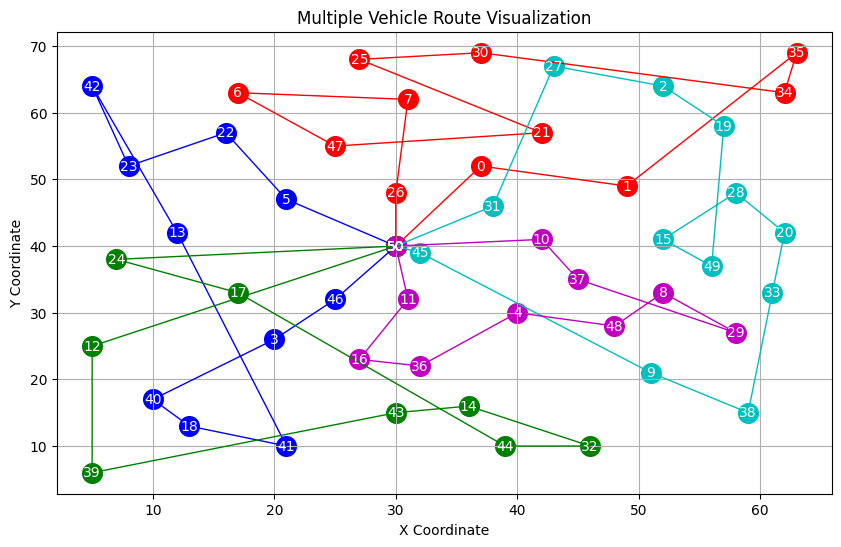

Solution: [[50, 46, 3, 40, 18, 41, 13, 42, 23, 22, 5, 50], [50, 12, 39, 43, 14, 32, 44, 17, 24, 50], [50, 26, 7, 6, 47, 21, 25, 30, 34, 35, 1, 0, 50], [50, 45, 9, 38, 33, 20, 28, 15, 49, 19, 2, 27, 31, 50], [50, 10, 37, 29, 8, 48, 4, 36, 16, 11, 50]]
Route for vehicle 0:
 50 Load(0) -> 46 Load(25.0) -> 3 Load(34.0) -> 40 Load(61.0) -> 18 Load(70.0) -> 41 Load(83.0) -> 13 Load(104.0) -> 42 Load(115.0) -> 23 Load(125.0) -> 22 Load(141.0) -> 5 Load(156.0) -> 50 Load(156.0)
Distance of the route: 144.95558378617415m
Load of the route: 156.0

Route for vehicle 1:
 50 Load(0) -> 12 Load(23.0) -> 39 Load(30.0) -> 43 Load(46.0) -> 14 Load(56.0) -> 32 Load(79.0) -> 44 Load(89.0) -> 17 Load(130.0) -> 24 Load(158.0) -> 50 Load(158.0)
Distance of the route: 165.5648798797966m
Load of the route: 158.0

Route for vehicle 2:
 50 Load(0) -> 26 Load(15.0) -> 7 Load(38.0) -> 6 Load(57.0) -> 47 Load(74.0) -> 21 Load(82.0) -> 25 Load(89.0) -> 30 Load(100.0) -> 34 Load(117.0) -> 35 Load(123.0) -> 1 Load(15

In [ ]:
depot_idx = 50
vehicle_capacity = 160
coordinates = coord
solution = genetic_algorithm(dist_matrix, demand, depot_idx, vehicle_capacity)
routes = solution
clear_output(wait=True)
visualize_multiple_routes(coordinates, routes)
print(f"Solution: {solution}")
print_solution(solution, dist_matrix, demand, depot_idx)

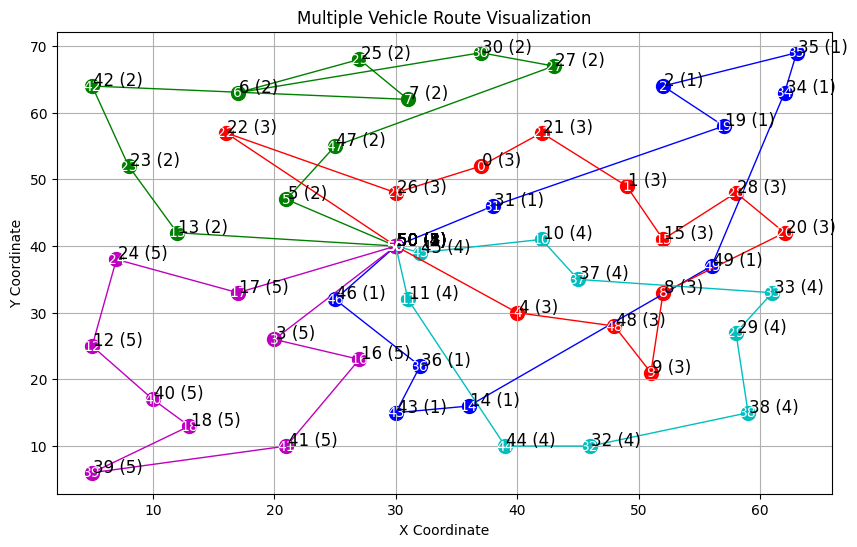

In [ ]:
# Example input
coordinates = coord
routes = solution
visualize_multiple_routes(coordinates, routes)